# MDD full and stochastic - Volve synthetic data

**Author: M.Ravasi**

This notebook applies multi-dimensional deconvolution to synthetic up/down separared Volve data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve, convolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.interpolate import RegularGridInterpolator

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *

from segyshot import SegyShot
from calibrate import calibrate
from wavsep_utils import *
from stochmdd import MDDminibatch
from steepest import *

In [2]:
def Mask_XT(
    trav: np.ndarray,
    t: np.ndarray,
    toff: float,
    nsmooth: float,
) -> np.ndarray:
    """Causality mask in the time-space domain used to remove events arriving
    before the direct wave in a reflection data set. It is built using direct
    wave arrivals from an eikonal solver, t(xr, xs).

    :param trav: Eikonal traveltimes, (nr, ns)
    :param t: Time axis, (nt,)
    :param toff: Time 'Epsilon' shift in the mask
    :param nsmooth: Smoothing parameter

    :return: Causality Preconditioner mask, (nt, nr, ns)
    """
    # Define window size
    nt = t.size
    nr, ns = trav.shape

    # Replicate along time axis
    trav = np.tile(trav, (nt, 1, 1))
    trav_off = trav - toff

    # Build mask
    C = (t * np.ones([nt, nr, ns]).transpose(2, 1, 0)).transpose(2, 1, 0)
    C = (C > trav_off).astype(np.int)

    # Smooth adges
    if nsmooth > 0:
        smooth = np.ones(nsmooth) / nsmooth
        C = filtfilt(smooth, 1, C)

    # extend to negative time [-t, t]
    C = np.concatenate((np.zeros([nt, nr, ns]), C[1:, :, :]), axis=0)

    return C

## Parameters

In [3]:
# Wavefield separation
method = 'src_ana'
preloaded = True

## Compare real and synthetic shots

Real data

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


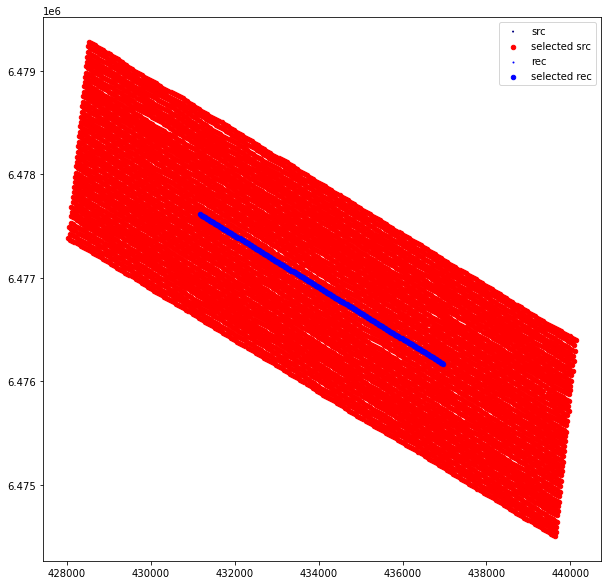

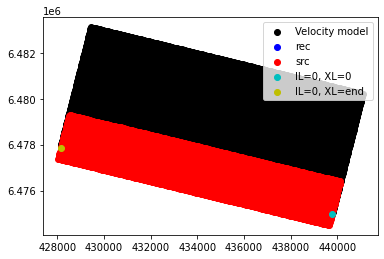

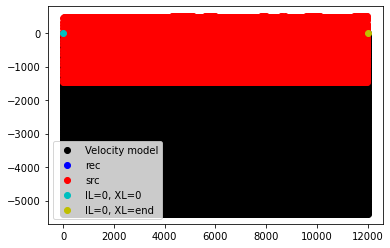

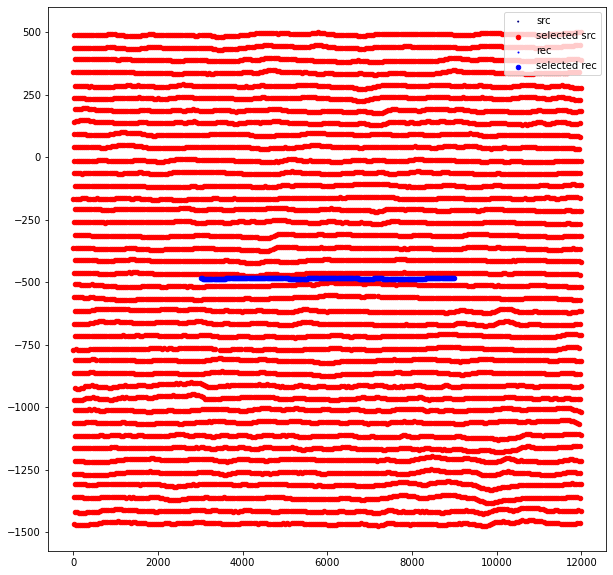

In [4]:
velfilepath = '/home/ravasim/Documents/Data/Volve/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
filepath = '/home/ravasim/Documents/Data/Volve/'
datapath = 'Data' # to save intermediate results

inputfile = os.path.join(filepath, 'ST10010_1150780_40203.sgy')
f = segyio.open(inputfile, ignore_geometry=True)

ishotc = 5520
ishotin, ishotend = ishotc-120, ishotc+120
irecin, irecend = 30, 210

sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()

_,_,_,_, (xvel_local, yvel_local) = \
    sg.rotategeometry(velfile=velfilepath, plotflag=1)
sg.showgeometry(local=True)

# Select shot
sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(ishotin, ishotend, plotflag=False)

sg.selectsrcs(ishotc, ishotc+1, plotflag=False)
sg.showgeometry(local=True)
plt.scatter(xvel_local, yvel_local, c='k', s=.2)

drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = sg.srcx_local[ishotc] - sg.recx_local[sg.selected_rec]
shot = sg.get_shotgather(ishotc)

Synthetic data

In [5]:
fsynth = np.load('/home/ravasim/Documents/Madagascar/RSFSRC/book/mrava/mddstoch/volve_synthdata/input_full_volvesynth.npz') 
fsynth_nofs = np.load('/home/ravasim/Documents/Madagascar/RSFSRC/book/mrava/mddstoch/volve_synthdata/input_nofs_full_volvesynth.npz') 
fsynth_seabed = np.load('/home/ravasim/Documents/Madagascar/RSFSRC/book/mrava/mddstoch/volve_synthdata/input_nosea_full_volvesynth.npz') 
fsynth_seabedflat = np.load('/home/ravasim/Documents/Madagascar/RSFSRC/book/mrava/mddstoch/volve_synthdata/input_noseaflat_volvesynth.npz') 

psynth = fsynth['p'].transpose(0, 2, 1)
vzsynth = fsynth['vz'].transpose(0, 2, 1)
psynth_nofs = fsynth_nofs['p'].transpose(0, 2, 1)
psynth_nosea = fsynth_seabed['p'].transpose(0, 2, 1)
psynth_noseaflat = fsynth_seabedflat['pflat']
tsynth = fsynth['t']
rsynth = fsynth['r']
ssynth = fsynth['s']
t = fsynth['t']
wav = fsynth['wav']

offsynth = ssynth[0, 59] - rsynth[0]
offset = sg.srcx_local[ishotc] - sg.recx_local[sg.selected_rec]

ns, nr, nt = psynth.shape
dr = np.round(rsynth[0,1]-rsynth[0,0])
dt = t[1]-t[0]

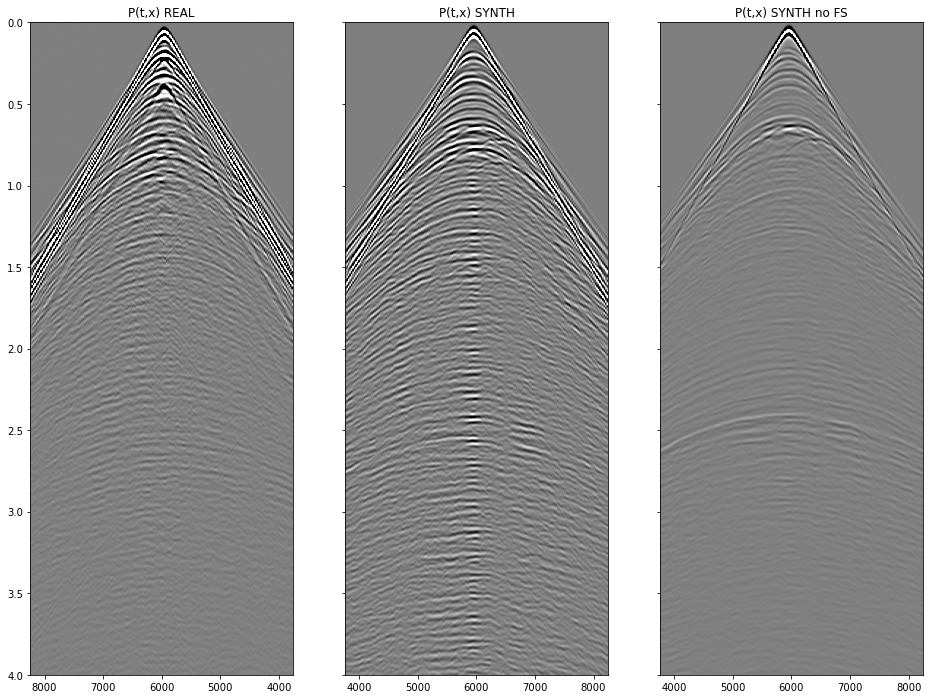

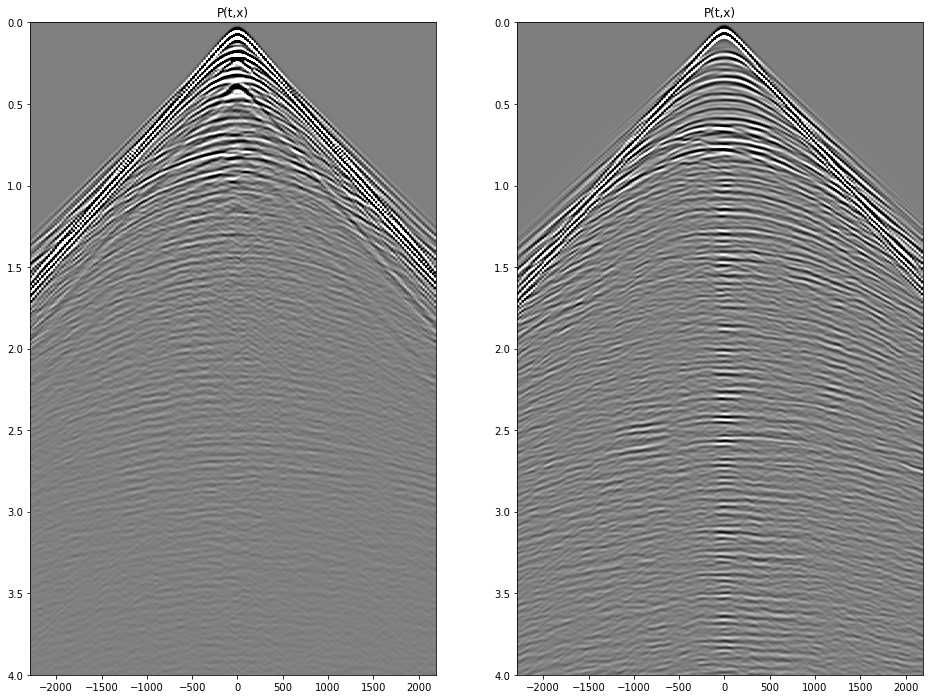

In [6]:
gain = np.sqrt(sg.t)

preal = -np.apply_along_axis(convolve, -1, shot['P'], wav, mode='full')
preal = preal[..., np.argmax(wav):][..., :len(sg.t)]
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 12))
axs[0].imshow(preal.T * gain[:, np.newaxis], cmap='gray', vmin=-2e6, vmax=2e6,
              extent = (sg.recx_local[sg.selected_rec][0], sg.recx_local[sg.selected_rec][-1], sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x) REAL')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_title('P(t,x) SYNTH')
axs[1].axis('tight')
axs[2].imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title('P(t,x) SYNTH no FS')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('Figs/Volve_real_vs_synth.png')

fig, axs = plt.subplots(1, 2, figsize=(16, 12))
axs[0].imshow(preal.T * gain[:, np.newaxis], cmap='gray', vmin=-2e6, vmax=2e6,
              extent = (offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(np.fliplr(psynth[59].T), cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (offsynth[-1], offsynth[0], tsynth[-1], tsynth[0]))
axs[1].set_title('P(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(4, 0);

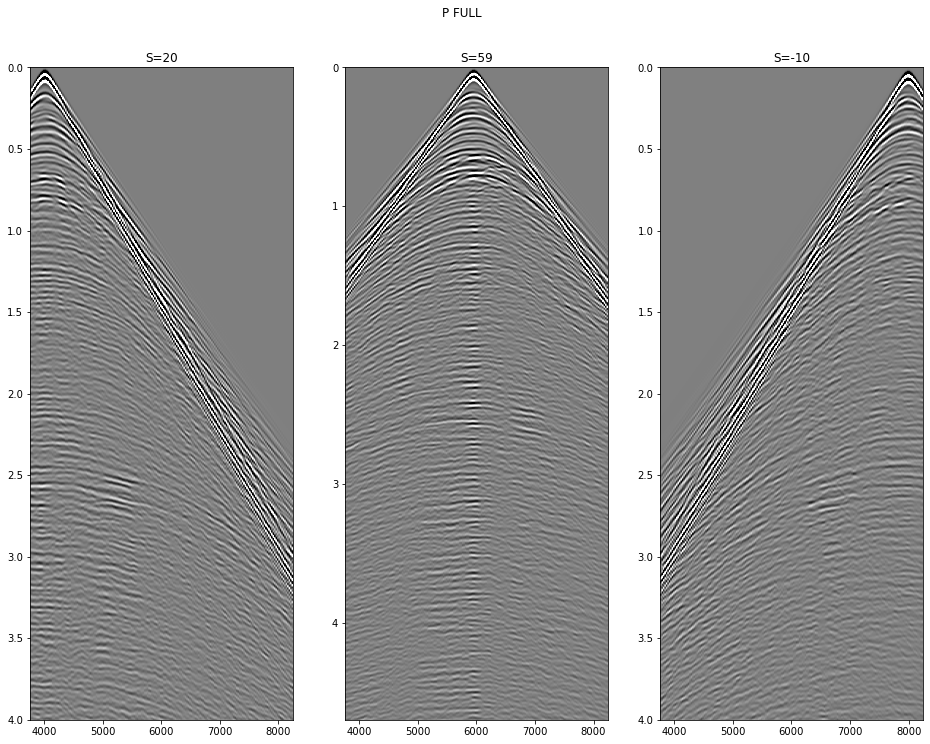

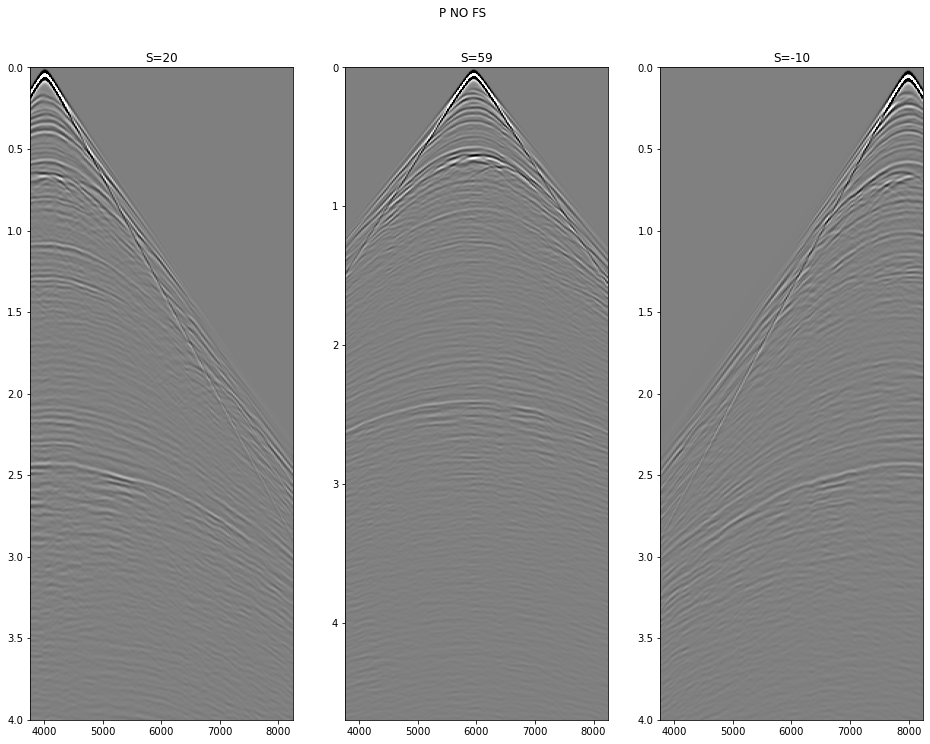

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P FULL', y=0.95)
axs[0].imshow(psynth[20].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_title('S=20')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_title('S=59')
axs[1].axis('tight')
axs[2].imshow(psynth[-10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title('S=-10')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('Figs/Volve_synthdata_p.png')

fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P NO FS', y=0.95)
axs[0].imshow(psynth_nofs[20].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_title('S=20')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_title('S=59')
axs[1].axis('tight')
axs[2].imshow(psynth_nofs[-10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title('S=-10')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('Figs/Volve_synthdata_pnofs.png')

fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P NO SEA', y=0.95)
axs[0].imshow(psynth_nosea[10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_title('S=10')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(psynth_nosea[90].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_title('S=90')
axs[1].axis('tight')
axs[2].imshow(psynth_nosea[-10].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title('S=-10')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('Figs/Volve_synthdata_pnosea.png');

## Wavefield separation

Create separation operators

In [8]:
# separation
nfft=nt
vel_dir = 1480.0 # velocity of water
vel_sep = 1900.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level
critical = 0.9
ntaper = 9 # 7
cutoff = 1e7 # 1e8

# calibration params
twin = [0.01, 0.07]
nfilt = 15

# fft
FFTop = FFT2D(dims=[nr, nt], 
              nffts=[nfft, nfft], sampling=[dr, dt])

#obliquity factor
[Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
k=F/vel_sep
Kz=np.sqrt((k**2-Kx**2).astype(np.complex))
Kz[np.isnan(Kz)] = 0

# obliquities
OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0
OBL[OBL>cutoff]=0

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1[OBL1<1./cutoff]=0

# cut off and taper
mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=0)
mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=1)

OBL = OBL*mask
OBL1 = OBL1*mask

# analytical separation
Maskop = Diagonal(mask.ravel(), dtype='complex128')
OBLop = Diagonal(OBL.ravel(), dtype='complex128')

Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
    Block([[Maskop, OBLop],
           [Maskop, -OBLop]])*\
           BlockDiag([FFTop, FFTop]))

In [9]:
if not preloaded:
    pup = np.zeros((ns, nt, nr))
    pdown = np.zeros((ns, nt, nr))

    for isrc in range(0, ns):
        if isrc % 10 == 0:
            print(f'Working with source {isrc}/{ns}')
        vzcalib = calibrate(psynth[isrc], vzsynth[isrc], ssynth, rsynth, isrc, dt, nt, vel_dir, vel_sep, 
                            rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

        d = np.concatenate((psynth[isrc].ravel(), vzcalib.ravel()))
        dud = np.real(Sop*d)

        d = d.reshape(2*nr, nt)
        dud = dud.reshape(2*nr, nt)
        pdown[isrc], pup[isrc] = dud[:nr].T, dud[nr:].T

In [10]:
if not preloaded:
    p_zo = np.zeros((ns, nt))
    pup_zo = np.zeros((ns, nt))
    pdown_zo = np.zeros((ns, nt))

    for isrc in range(ns):
        irec_zo = np.argmin(np.abs(ssynth[0, isrc]-rsynth[0]))
        p_zo[isrc] = psynth[isrc, irec_zo]
        pup_zo[isrc], pdown_zo[isrc] = pup[isrc, :, irec_zo], pdown[isrc, :, irec_zo]

    clip = 0.1
    fig, axs = plt.subplots(1, 3, figsize=(17,10))
    axs[0].imshow(p_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
                  extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
    axs[0].set_title(r'$p$ Zero-offset')
    axs[0].axis('tight')
    axs[0].set_ylim(1.5, 0)
    axs[1].imshow(pdown_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
                  extent = (rsynth[0,0], rsynth[0,-1], t[-1], t[0]))
    axs[1].set_title(r'$p^+$ Zero-offset')
    axs[1].axis('tight')
    axs[1].set_ylim(1.5, 0)
    axs[2].imshow(pup_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
                  extent = (rsynth[0,0], rsynth[0,-1], t[-1], t[0]))
    axs[2].set_title(r'$p^-$ Zero-offset')
    axs[2].axis('tight')
    axs[2].set_ylim(1.5, 0);

In [11]:
if not preloaded:
    fig, axs = plt.subplots(1, 2, figsize=(16,9))
    axs[0].imshow(psynth[ns//2].T, cmap='gray', vmin=-clip*np.abs(psynth).max(), vmax=clip*np.abs(psynth).max(),
                  extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
    axs[0].set_title(r'$p$')
    axs[0].axis('tight')
    axs[0].set_ylim(2.5, 0)
    axs[1].imshow(vzsynth[ns//2].T, cmap='gray', vmin=-clip*np.abs(vzsynth).max(), vmax=clip*np.abs(vzsynth).max(),
                  extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
    axs[1].set_title(r'$vz$')
    axs[1].axis('tight')
    axs[1].set_ylim(2.5, 0)

    fig, axs = plt.subplots(1, 2, figsize=(16,9))
    axs[0].imshow(pup[ns//2], cmap='gray', vmin=-clip*np.abs(psynth).max(), vmax=clip*np.abs(psynth).max(),
                  extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
    axs[0].set_title(r'$pup$')
    axs[0].axis('tight')
    axs[0].set_ylim(2.5, 0)
    axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-clip*np.abs(psynth).max(), vmax=clip*np.abs(psynth).max(),
                  extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
    axs[1].set_title(r'$pdown$')
    axs[1].axis('tight')
    axs[1].set_ylim(2.5, 0);

In [12]:
if not preloaded:
    for ishot in np.arange(ns):
        rfile = 'Volveimaging/pup_synth_shot%d.bin' % ishot
        with open(rfile, 'wb') as f: # write for madagascar
            pup[ishot].astype(np.float32).tofile(f)
            
if not preloaded:
    method = 'src_ana'
    np.savez(os.path.join(datapath, 'updown_volvesynth_belowseabed_%s' % method), pup=pup, pdown=pdown)

In [13]:
if preloaded:
    f = np.load(os.path.join(datapath, 'updown_volvesynth_belowseabed_%s.npz' % method))
    pup = f['pup']
    pdown = f['pdown']
    nt = pup.shape[1]
    pup.shape

## Single virtual source MDD

scaling = 1e3
pdown /= scaling
pup /= scaling

In [14]:
pdown = pdown.transpose(1, 0, 2)
pup = pup.transpose(1, 0, 2)

2351
2401


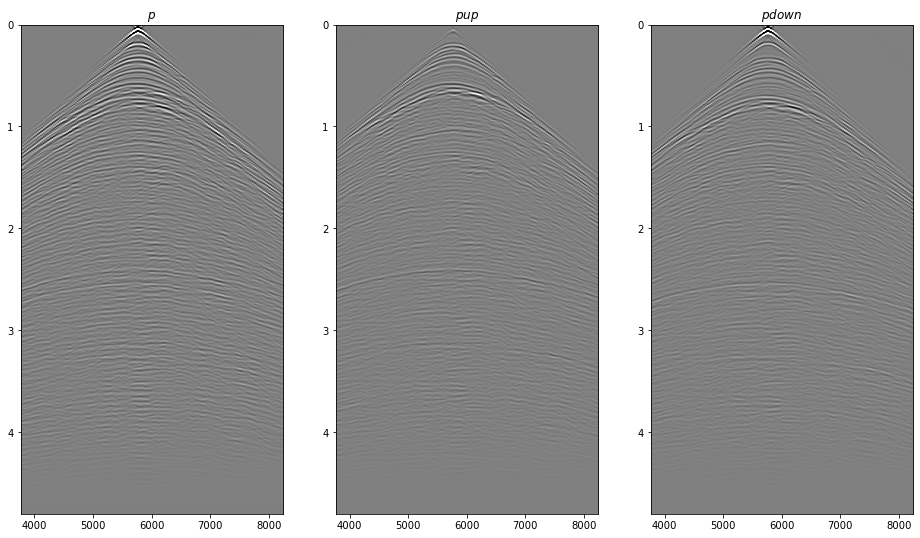

In [15]:
# Taper late time
taper = taper2d(110, nt, 500)
taper[:600] = 1 

pup = taper[...,np.newaxis] * pup
pdown = taper[...,np.newaxis] * pdown

# Pad data with zero at the end (to avoid wrap around)
npad = 50
print(nt)
pdown = np.pad(pdown, ((0, npad), (0, 0), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, npad), (0, 0), (0, 0))).astype('float32')
psynth_noseaflat = np.pad(psynth_noseaflat, ((0, npad), (0, 0))).astype('float32')
nt = pup.shape[0]
t = np.arange(nt) * dt
print(nt)

fig, axs = plt.subplots(1, 3, figsize=(16,9))
axs[0].imshow(pup[:, ns//2]+pdown[:, ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(pup[:, ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pup$')
axs[1].axis('tight')
axs[2].imshow(pdown[:, ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0,0], rsynth[0,-1], t[-1], t[0]))
axs[2].set_title(r'$pdown$')
axs[2].axis('tight');

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16,9))
axs[0].imshow(pup[:, 59]+pdown[:, 59], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(pup[:, 59], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pup$')
axs[1].axis('tight')
axs[2].imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title(r'$pnofs$')
axs[2].axis('tight')
axs[2].set_ylim(3, 0);

fig, ax = plt.subplots(1, 1,  figsize=(5,9))
ax.imshow(pup[:, 59], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
ax.axis('tight')
ax.set_ylim(3, 0);

fig, ax = plt.subplots(1, 1,  figsize=(5,9))
ax.imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
ax.axis('tight')
ax.set_ylim(3, 0);

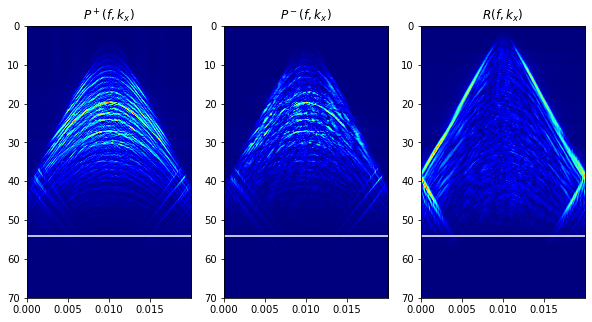

In [17]:
nfft = nt
nfmax = 230
FFTop = FFT2D(dims=[nr, nt], 
              nffts=[nfft, nfft], sampling=[dr, dt])

PUP = (FFTop*pup[:, ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[:, ns//2].T.flatten()).reshape(nfft, nfft)

# mask away high freqs in true response
RTRUE = (FFTop*psynth_noseaflat.T.ravel()).reshape(nfft, nfft)

mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
Rtrue = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, nt).T
nfmax += 30 # Add some extra frequencies where Rtrue has not been cut to zero (inside taper)

fig, axs = plt.subplots(1, 3, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

### Benchmark MDD

In [18]:
def errnorm(m, mtrue, enorm, enormwin=None):
    if not enormwin:
        mmax = m.max() if m.max() != 0 else 1
        mtruemax = mtrue.max() if mtrue.max() != 0 else 1
    else:
        mmax = m.reshape(mtrue.shape)[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() if m.reshape(mtrue.shape)[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() != 0 else 1
        mtruemax = mtrue[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() if mtrue[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() != 0 else 1
    enorm.append(np.linalg.norm(m/mmax - mtrue.ravel()/mtruemax))

In [19]:
# TX mask
mask = np.fft.fftshift(Mask_XT(np.abs(rsynth[0]-rsynth[0, np.newaxis].T) / 1900, t[:nt//2+1], 0, 10), axes=0)
mask[nt//2-40:nt//2+600] = 1.
Mop = Diagonal(mask[:, nr//2].ravel())

In [20]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=1, dt=dt, dr=dr, 
            twosided=False, transpose=False)
# Adjoint
Radj = MDCop.H * pup[:, :, nr//2].ravel()
Radj = np.real(Radj).reshape(nt, nr)

In [21]:
# Inverse
niter = 30
errorwin = [250,400,60,120]

Rinv_error = []
Rinv, _, _, _, _, Rinv_res = \
    cgls(MDCop * Mop, pup[:, :, nr//2].ravel(), niter=niter, 
         x0=np.zeros((nt, nr)).ravel(), damp=1e-9, tol=0., show=1,
         callback=lambda x: errnorm(x, Rtrue, Rinv_error, enormwin=errorwin),)
Rinv = np.real(Mop * Rinv).reshape(nt, nr)
Rinv_res = Rinv_res**2 / (nt * ns)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, ns)

CGLS
-----------------------------------------------------------
The Operator Op has 264110 rows and 432180 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 30
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         0.0000e+00         8.1836e+04      8.1836e+04
     2         0.0000e+00         6.7382e+04      6.7382e+04
     3         0.0000e+00         5.9442e+04      5.9442e+04
     4         0.0000e+00         5.4251e+04      5.4251e+04
     5         0.0000e+00         4.9935e+04      4.9935e+04
     6         0.0000e+00         4.6603e+04      4.6603e+04
     7         0.0000e+00         4.3830e+04      4.3830e+04
     8         0.0000e+00         4.1511e+04      4.1511e+04
     9         0.0000e+00         3.9622e+04      3.9622e+04
    10         0.0000e+00         3.8152e+04      3.8152e+04
    20         0.0000e+00         3.0763e+04      3.0763e+04
    21         0.0000e+00         3.0351e+04   

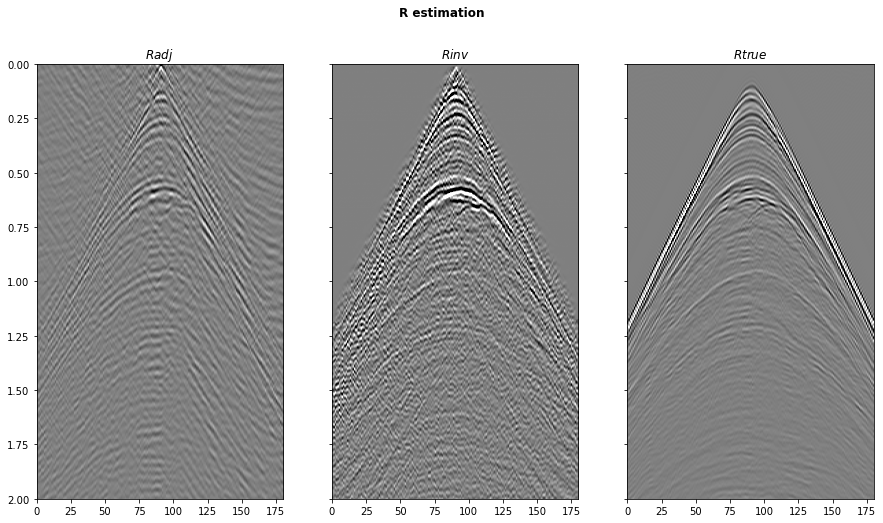

In [22]:
clip = 0.3
itmax = 2000
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(Radj[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rtrue[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rtrue).max(), vmax=clip*np.abs(Rtrue).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

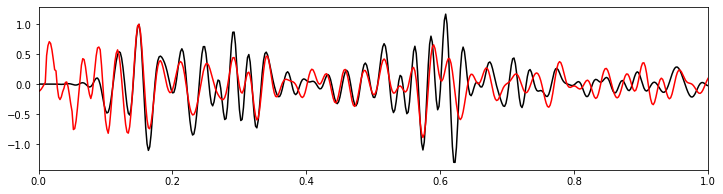

In [23]:
plt.figure(figsize=(12, 3))
plt.plot(t, Rtrue[:, nr//2] / Rtrue[50:100, nr//2].max(), 'k')
plt.plot(t, Rinv[:, nr//2] / Rinv[50:100, nr//2].max(), 'r')
plt.xlim(0, 1.);

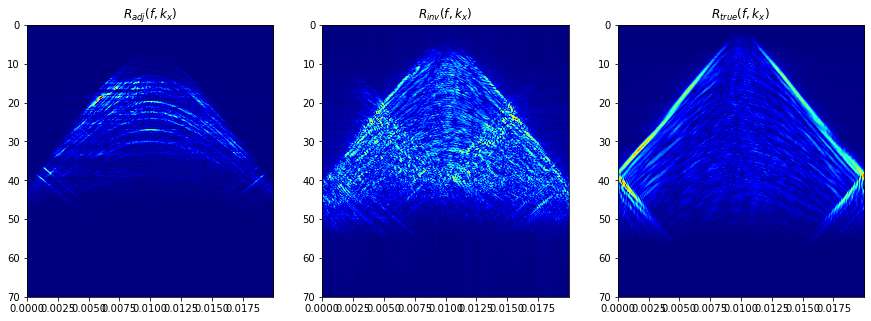

In [24]:
RADJ = (FFTop*Radj.T.ravel()).reshape(nfft, nfft)
RINV = (FFTop*Rinv.T.ravel()).reshape(nfft, nfft)
RTRUE = (FFTop*Rtrue.T.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(RADJ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RADJ).max())
axs[0].axhline(FFTop.f2[2*nfmax], color='w')
axs[0].set_title(r'$R_{adj}(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(RINV[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RINV).max())
axs[1].axhline(FFTop.f2[2*nfmax], color='w')
axs[1].set_title(r'$R_{inv}(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[2*nfmax], color='w')
axs[2].set_title(r'$R_{true}(f, k_x)$')
axs[2].axis('tight');
axs[2].set_ylim(70, 0);

### Steepest descent MDD

In [25]:
# analytical stepsize
m0 = np.zeros((nt, nr)).ravel()
Rsd, _, alphaana = steepest_descent(MDCop.H @ MDCop, MDCop.H @ pup[:, :, nr//2].ravel(), 
                                            niter=niter, m0=m0, a=None, tol=1e-3, savemhist=False)
Rsd = np.real(Rsd).reshape(nt, nr)

pupsd = MDCop * Rsd.ravel()
pupsd = pupsd.reshape(nt, ns)

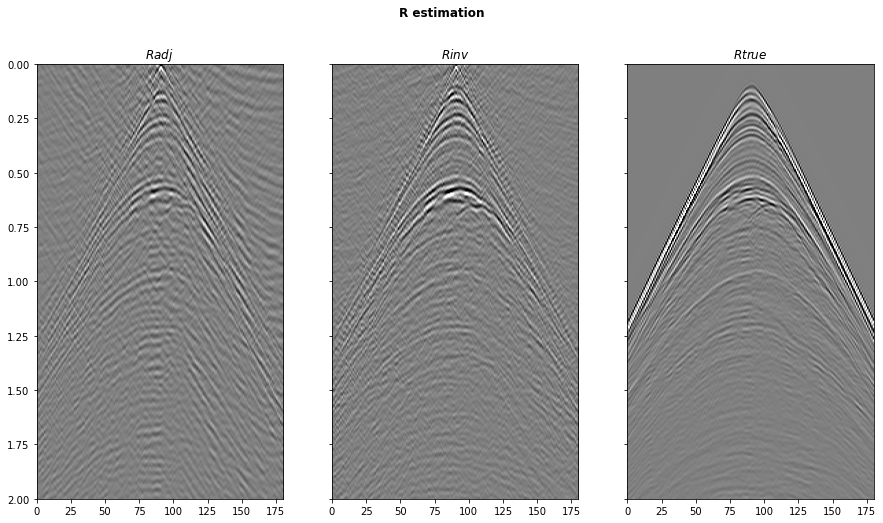

In [26]:
clip = 0.3
itmax = 2000
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(Radj[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rsd[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rsd).max(), vmax=clip*np.abs(Rsd).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rtrue[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rtrue).max(), vmax=clip*np.abs(Rtrue).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

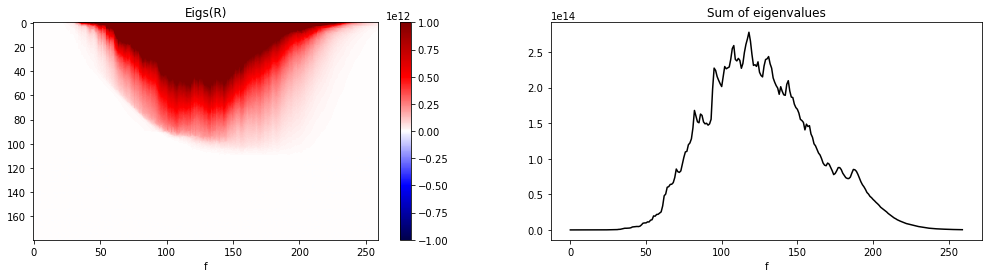

In [27]:
eigmax = (MDCop.H @ MDCop).eigs(neigs=1)

PDOWN = dt * dr * np.sqrt(nt) * np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

eigs = np.linalg.eig(np.matmul(np.conj(PDOWN.transpose(0,2,1)), PDOWN))[0]
eigs = np.fliplr(np.sort(np.abs(eigs), axis=1))

fig, axs = plt.subplots(1, 2, figsize=(17, 4))
im = axs[0].imshow(eigs.T, cmap='seismic', vmin=-1e12, vmax=1e12)
axs[0].set_title('Eigs(R)')
axs[0].set_xlabel('f')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
axs[1].plot(np.sum(eigs, axis=1), 'k')
axs[1].set_title('Sum of eigenvalues')
axs[1].set_xlabel('f');

4.8100186574171927e-14 4.810018657417198e-14


array([5.86852796e-14, 4.68878084e-14, 5.71367960e-14, 4.58861417e-14,
       5.49673774e-14, 4.45724983e-14, 5.36404891e-14, 4.40697753e-14,
       5.32671970e-14, 4.39436066e-14, 5.31642867e-14, 4.38942620e-14,
       5.31006269e-14, 4.38515465e-14, 5.30376449e-14, 4.38087428e-14,
       5.29764273e-14, 4.37686074e-14, 5.29208047e-14, 4.37329816e-14,
       5.28723025e-14, 4.37023062e-14, 5.28309832e-14, 4.36764077e-14,
       5.27964353e-14, 4.36549739e-14, 5.27681959e-14, 4.36377008e-14,
       5.27458285e-14, 4.36242932e-14])

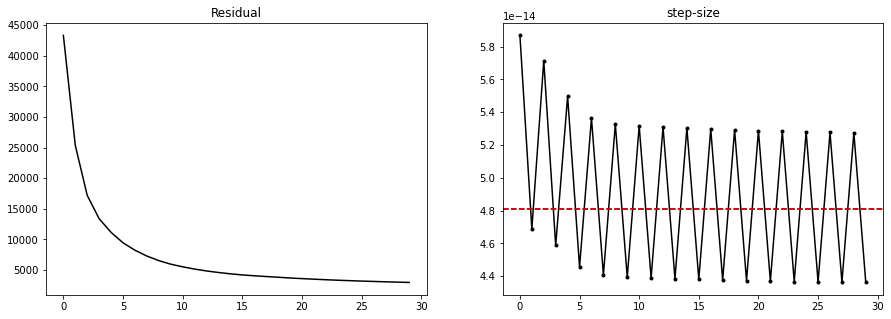

In [28]:
alphamax1 = 2. / eigs.max() 
alphamax = 2. / np.real(eigmax[0])
print(alphamax1, alphamax)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(Rinv_res, 'k')
axs[0].set_title('Residual')
axs[1].plot(alphaana, '.-k')
axs[1].axhline(alphamax, c='k', linestyle='--')
axs[1].axhline(alphamax1, c='r', linestyle='--')
axs[1].set_title('step-size');

alphaana

In [29]:
# fixed stepsize inversion
alphamax = 1.9 / np.real(eigmax[0])
m0 = np.zeros((nt, nr)).ravel()
Rsd, _, alphaana = steepest_descent(MDCop.H @ MDCop, MDCop.H @ pup[:, :, nr//2].ravel(), 
                                     niter=niter, m0=m0, a=alphamax, tol=1e-3, savemhist=False)
Rsd = np.real(Rsd).reshape(nt, nr)

pupsd = MDCop * Rsd.ravel()
pupsd = pupsd.reshape(nt, ns)

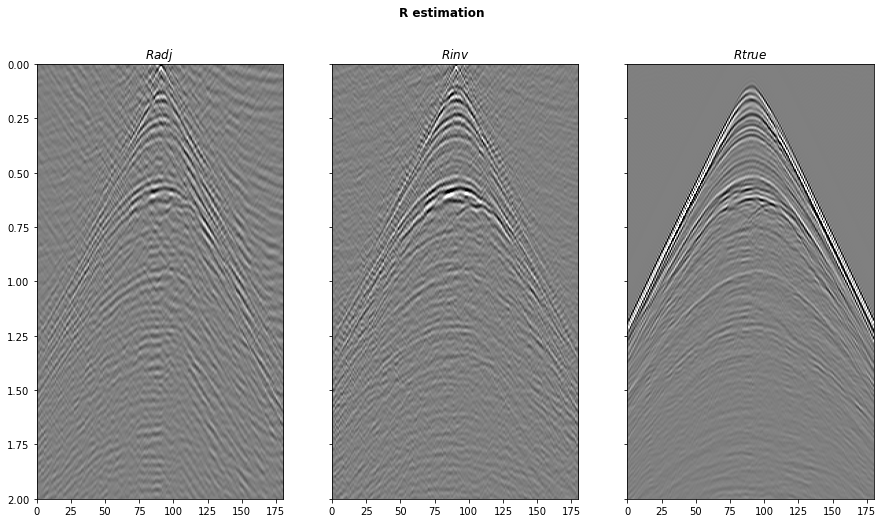

In [30]:
clip = 0.3
itmax = 2000
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(Radj[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rsd[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rsd).max(), vmax=clip*np.abs(Rsd).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rtrue[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rtrue).max(), vmax=clip*np.abs(Rtrue).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

### Stochastic MDD

In [31]:
# Identify learning-rate based on steepest descent first step / analytical upper bound.
# To make it equivalent to analytic steepest descent, denominator compensates for 
# different norm used in torch which is normalized by number of elements
lrstmax = alphamax # from steepest descent notebook
lrstmax * ((nt*ns)/2) 

6.0342766311496665e-09

In [32]:
nepochs = niter
batch_size = 32

no_of_batches= int(np.ceil(ns/batch_size))
lossdict = {}
avgdict = {}
lossepochdict = {}
enormdict = {}
mdict = {}

In [33]:
PDOWN = np.fft.rfft(pdown, nt, axis=0).astype(np.complex64)
PDOWN = PDOWN[:nfmax]

timemask = torch.from_numpy(mask[:, nr//2])
Rtrue = torch.from_numpy(Rtrue)
PDOWN = torch.from_numpy(PDOWN)
pup2d = torch.from_numpy(pup[..., nr//2])

In [34]:
lr = {}
lr[32] = 2e-9

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(nt, nr, dt, dr, PDOWN, pup2d, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rtrue, enormwin=errorwin,
                              seed=0, epochprint=5,
                              timemask=timemask,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

Initial Gradient norm: 2.681133e+12, scaled by lr: 1.072453e-05
Initial Gradient norm as np.linalg.norm: 6.290300e+10, scaled by nbatches:  2.162291e+11
epoch:   5, loss : 1.1977e+04, loss avg : 1.6140e+04
epoch:  10, loss : 1.4008e+04, loss avg : 1.1946e+04
epoch:  15, loss : 7.9073e+03, loss avg : 9.1213e+03
epoch:  20, loss : 6.4668e+03, loss avg : 7.8303e+03
epoch:  25, loss : 8.4240e+03, loss avg : 7.3711e+03
epoch:  30, loss : 8.5818e+03, loss avg : 6.8864e+03
Final Model norm: 3.873989e-03


In [35]:
# First loss 
np.sum(np.abs(pup2d.reshape(-1).numpy())**2) / (len(pup2d.reshape(-1))), lossepochdict['SGD'][0], Rinv_res[0]

(43350.2651470978, 43350.26171875, 43350.26265197979)

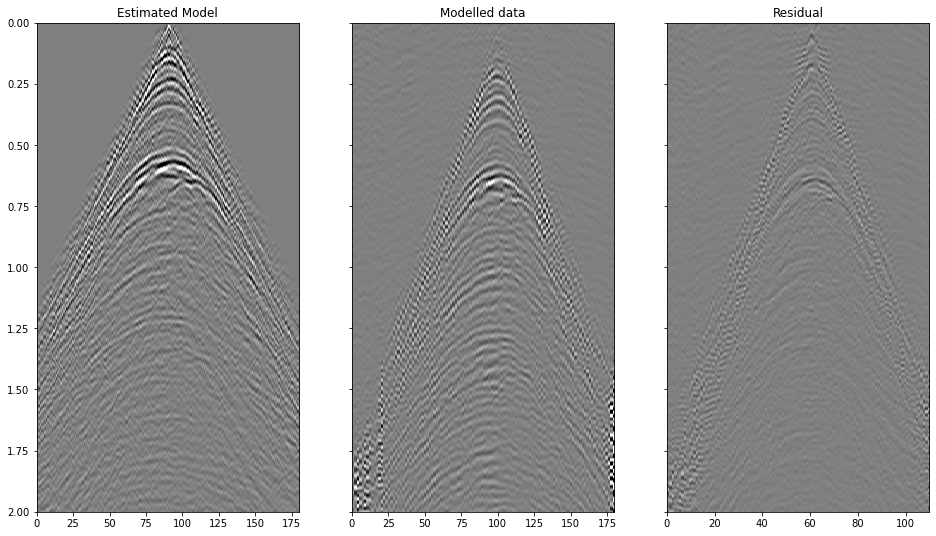

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup2d).max(), vmax=clip*np.abs(pup2d).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup2d).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup2d).max(), vmax=clip*np.abs(pup2d).max(),
           extent = (0, ns, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2., 0);

In [49]:
lr = {}
lr[32] = 1e-9

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(nt, nr, dt, dr, PDOWN, pup2d, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rtrue, enormwin=errorwin,
                              seed=0, epochprint=5,
                              timemask=timemask,
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()

Initial Gradient norm: 2.681133e+12, scaled by lr: 2.681133e-06
Initial Gradient norm as np.linalg.norm: 6.290300e+10, scaled by nbatches:  2.162291e+11
epoch:   5, loss : 9.1240e+03, loss avg : 1.1748e+04
epoch:  10, loss : 8.8292e+03, loss avg : 8.2874e+03
epoch:  15, loss : 5.1348e+03, loss avg : 6.2092e+03
epoch:  20, loss : 4.2110e+03, loss avg : 5.9723e+03
epoch:  25, loss : 6.2456e+03, loss avg : 6.8538e+03
epoch:  30, loss : 6.1352e+03, loss avg : 7.6841e+03
Final Model norm: 6.589802e-03


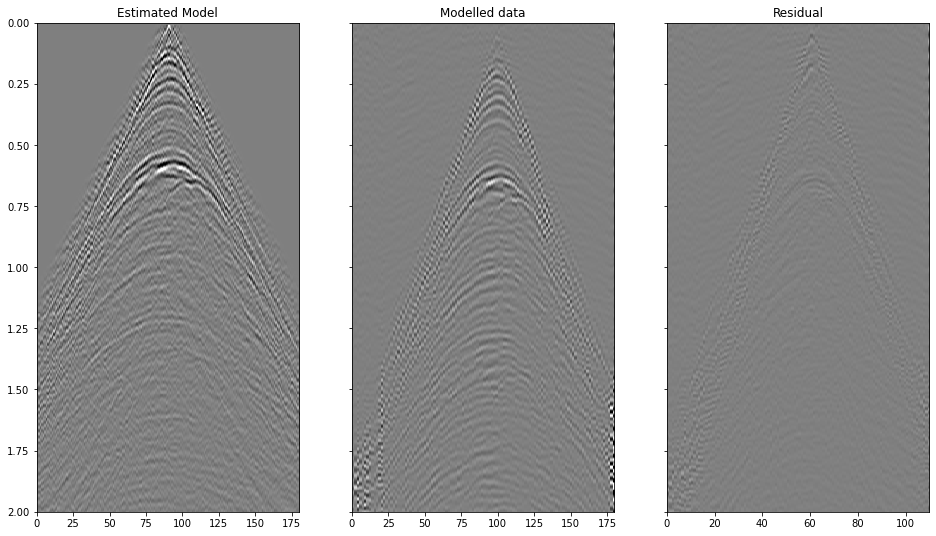

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup2d).max(), vmax=clip*np.abs(pup2d).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup2d).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup2d).max(), vmax=clip*np.abs(pup2d).max(),
           extent = (0, ns, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2., 0);

In [51]:
lr = {}
lr[32] = 1e-9

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'],  enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(nt, nr, dt, dr, PDOWN, pup2d, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rtrue, enormwin=errorwin,
                              seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5,
                              timemask=timemask,
                              kwargs_sched=dict(gamma=0.97, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

Initial Gradient norm: 2.681133e+12, scaled by lr: 2.681133e-06
Initial Gradient norm as np.linalg.norm: 6.290300e+10, scaled by nbatches:  2.162291e+11
epoch:   5, loss : 9.9181e+03, loss avg : 1.2634e+04
epoch:  10, loss : 1.1129e+04, loss avg : 9.8022e+03
epoch:  15, loss : 7.1814e+03, loss avg : 8.3818e+03
epoch:  20, loss : 6.4209e+03, loss avg : 7.9164e+03
epoch:  25, loss : 8.8776e+03, loss avg : 8.0902e+03
epoch:  30, loss : 9.5152e+03, loss avg : 8.0901e+03
Final Model norm: 2.880121e-03


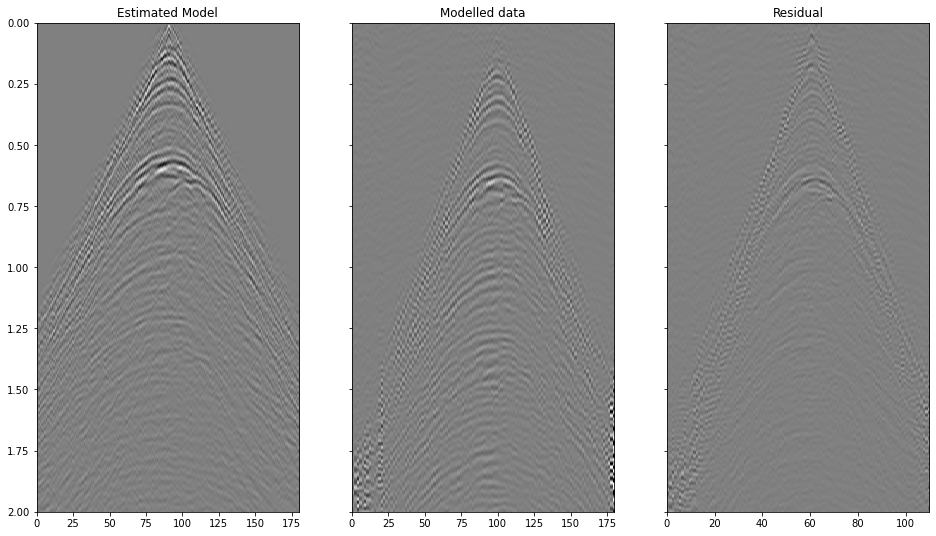

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup2d).max(), vmax=clip*np.abs(pup2d).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup2d).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup2d).max(), vmax=clip*np.abs(pup2d).max(),
           extent = (0, ns, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2., 0);

### Comparison

115.65233976841105
113.93558213921025
113.67024274732638
114.56643150468153


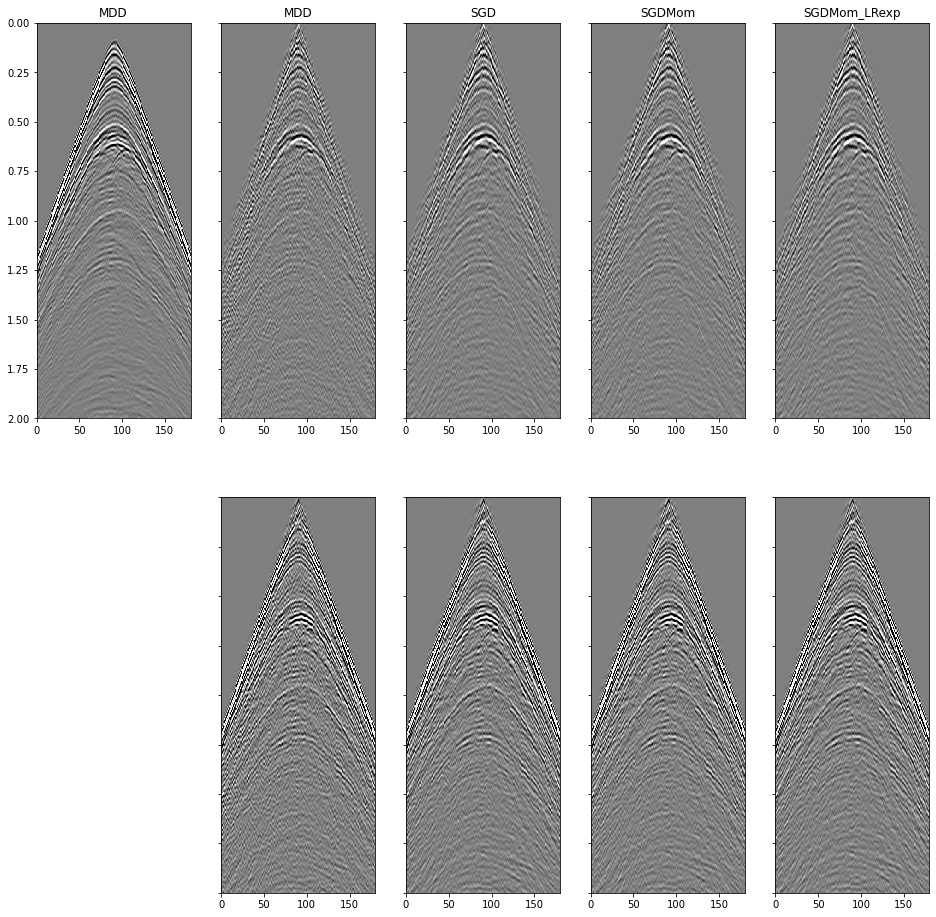

In [53]:
clip = 0.5
clip1 = 0.5
fig, axs = plt.subplots(2, 2+len(mdict), sharey=True, figsize=(16, 16))
axs[0][0].imshow(Rtrue, aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip*np.abs(Rtrue[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]]).max(), 
                 vmax=clip*np.abs(Rtrue[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]]).max(),
                 extent = (0, nr, t[-1], t[0]))
axs[0][0].set_title('MDD')
axs[1][0].axis('off')
axs[0][1].imshow(Rinv, aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]]).max(), 
                 vmax=clip*np.abs(Rinv[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]]).max(),
              extent = (0, nr, t[-1], t[0]))
axs[0][1].set_title('MDD')
axs[1][1].imshow(Rtrue/Rtrue[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max()-
                 Rinv/Rinv[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                  vmin=-clip1, vmax=clip1,
                  extent = (0, nr, t[-1], t[0]))
print(np.linalg.norm(Rtrue/Rtrue[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max()-
                 Rinv/Rinv[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max()))

for imod, mod in enumerate(mdict.keys()):
    axs[0][imod+2].imshow(mdict[mod], 
                          aspect='auto', interpolation='nearest', cmap='gray',
                          vmin=-clip*np.abs(mdict[mod][errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]]).max(), 
                          vmax=clip*np.abs(mdict[mod][errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]]).max(),
                          extent = (0, nr, t[-1], t[0]))
    axs[0][imod+2].set_title(mod)
    axs[1][imod+2].imshow(Rtrue/Rtrue[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max()-
                          mdict[mod]/mdict[mod][errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max(), 
                          aspect='auto', interpolation='nearest', cmap='gray',
                          vmin=-clip1, vmax=clip1,
                          extent = (0, nr, t[-1], t[0]))
    print(np.linalg.norm(Rtrue/Rtrue[errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max()-
                          mdict[mod]/mdict[mod][errorwin[0]:errorwin[1], errorwin[2]:errorwin[3]].max()))
axs[1][-1].set_ylim(2, 0);
#plt.savefig('Figs/Volvesynthsingle_solutions_batch%d_nepoch%d' % (batch_size, nepochs))

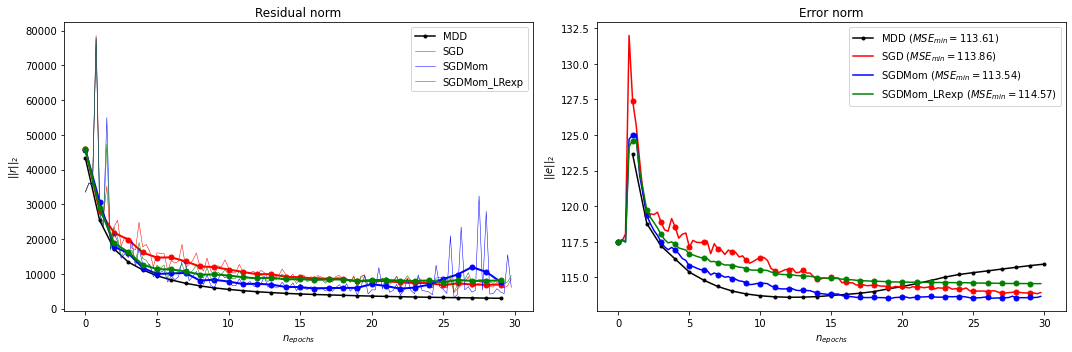

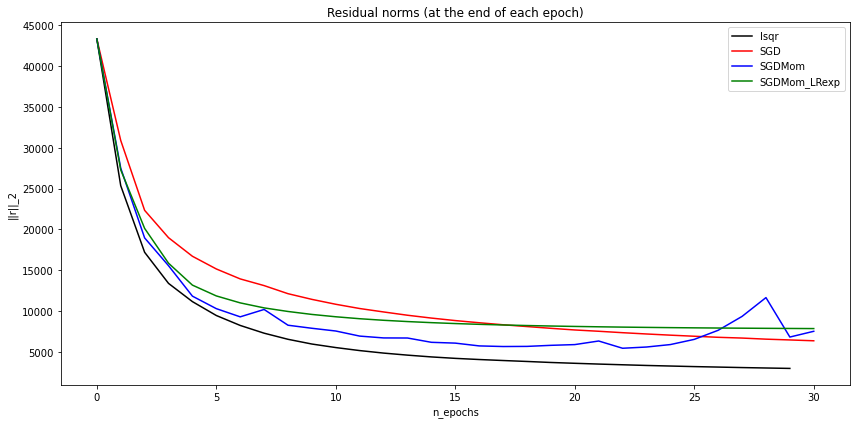

In [54]:
colors = ('r', 'b', 'g')

fig, axs = plt.subplots(1, 2, figsize= (15,5))
axs[0].plot(np.arange(nepochs), Rinv_res[:nepochs], '.-k', label="MDD")
for loss, avg, color in zip(lossdict.keys(), avgdict.keys(), colors):
    axs[0].plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches, avgdict[avg], 
                '.-%s' % color, ms=10, linewidth = 2)
    axs[0].plot(np.arange(len(lossdict[loss]))/no_of_batches , lossdict[loss], '%s' % color, label = loss, lw=0.5)
axs[0].set_xlabel(r'$n_{epochs}$')
axs[0].set_ylabel(r'$||r||_2$')
axs[0].set_title("Residual norm")
axs[0].legend()
axs[1].plot(np.arange(nepochs)+1, Rinv_error[:nepochs], '.-k', 
            label=r"MDD ($MSE_{min}=%.2f)$" % np.array(Rinv_error[:nepochs]).min())
for enorm, color in zip(enormdict.keys(), colors):
    axs[1].plot(np.arange(len(enormdict[enorm]))/no_of_batches, enormdict[enorm], 
                '%s' % color, ms=10, label=r"%s ($MSE_{min}=%.2f)$" % (enorm, np.array(enormdict[enorm]).min()))
    axs[1].plot((np.arange(len(enormdict[enorm]))/no_of_batches)[::no_of_batches], enormdict[enorm][::no_of_batches],
                '.%s' % color, ms=10, linewidth = 2)
axs[1].set_xlabel(r'$n_{epochs}$')
axs[1].set_ylabel(r'$||e||_2$')
axs[1].set_title("Error norm")
axs[1].legend()
fig.tight_layout()
plt.savefig('Figs/Volvesynthsingle_residual_error_norms_batch%d_nepoch%d' % (batch_size, nepochs))


fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/Volvesynthsingle_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

## Multi virtual source MDD

In [ ]:
# 10 vs
#reciprocity=False
#ivs = 5
#nvsin = nrecs//2-5
#nvsend = nrecs//2+6

# all vs
reciprocity = True #False
ivs = nr//2
nvsin = 0
nvsend = nr

nvs = nvsend-nvsin
nvs

### Benchmark MDD

In [ ]:
def errnorm(m, mtrue, enorm, nvs, ivs, enormwin=None):
    m = m.reshape(mtrue.shape[0], mtrue.shape[1], nvs)[...,ivs]
    if not enormwin:
        mmax = m.max() if m.max() != 0 else 1
        mtruemax = mtrue.max() if mtrue.max() != 0 else 1
    else:
        mmax = m.reshape(mtrue.shape)[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() if m.reshape(mtrue.shape)[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() != 0 else 1
        mtruemax = mtrue[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() if mtrue[enormwin[0]:enormwin[1],enormwin[2]:enormwin[3]].max() != 0 else 1
    enorm.append(np.linalg.norm(m.ravel()/mmax - mtrue.ravel()/mtruemax))

In [ ]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=nr, dt=dt, dr=dr, 
            twosided=False, transpose=False)

# Time mask
Mop = Diagonal(mask.ravel())

# Reciprocity prec
if reciprocity:
    Recop =  0.5 * (Identity(nt * nr * nr) + \
            Transpose((nt, nr, nr), (0, 2, 1)))
    MDCop = MDCop * Mop * Recop
else:
    MDCop = MDCop * Mop

# Adjoint
Radj = MDCop.H * pup[:, :, nvsin:nvsend].ravel()
Radj = np.real(Radj).reshape(nt, nr, nvs)

In [ ]:
# Inversion
bench_enorm = []
Rinv, _, _, _, _, bench_resnorm = \
    cgls(MDCop, pup[:, :, nvsin:nvsend].ravel(), niter=niter, 
         x0=np.zeros((nt, nr, nvs)).ravel(), damp=1e-9, tol=0., show=1,
         callback=lambda x: errnorm(x, Rtrue.numpy(), bench_enorm, nvs, ivs, enormwin=errorwin))
Rinv = np.real(Mop * Recop * Rinv).reshape(nt, nr, nr)
bench_resnorm = bench_resnorm**2 / (nt * ns * nvs)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, ns, nvs)

In [ ]:
clip = 0.5
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj[:, nr//2], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj[:, nr//2]).max(), vmax=clip*np.abs(Radj[:, nr//2]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[:, nr//2], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, nr//2]).max(), vmax=clip*np.abs(Rinv[:, nr//2]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift((pup-pupinv)[:, ns//2],axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, ns//2]).max(), vmax=clip*np.abs(pup[:, ns//2]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(2, -.9)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CSVG)', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj[:,  :, ivs+nvsin], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj[:,  :, ivs+nvsin]).max(), vmax=clip*np.abs(Radj[:,  :, ivs+nvsin]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[:, :, ivs], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, :, ivs+nvsin]).max(), vmax=clip*np.abs(Rinv[:, :, ivs+nvsin]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift((pup-pupinv)[:, :, ivs],axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, :, ivs]).max(), vmax=clip*np.abs(pup[:, :, ivs]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(2, -.9);

In [ ]:
clip = 0.3
itmax = 2000
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(Radj[:itmax, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(Radj[:itmax:, :, ivs]).max(), vmax=clip*np.abs(Radj[:itmax:, :, ivs]).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[:itmax:, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(Rinv[:itmax:, :, ivs]).max(), vmax=clip*np.abs(Rinv[:itmax:, :, ivs]).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rtrue[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rtrue[:itmax]).max(), vmax=clip*np.abs(Rtrue[:itmax]).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

### Stochastic MDD

In [ ]:
nepochs = niter
batch_size = 32

no_of_batches = int(np.ceil(ns/batch_size))
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
mdict = {}
ddict = {}

In [ ]:
PDOWN = np.fft.rfft(pdown, nt, axis=0).astype(np.complex64)
PDOWN = PDOWN[:nfmax]

PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[:, :, nvsin:nvsend])
timemask = torch.from_numpy(mask)

In [ ]:
pup.max(), torch.abs(PDOWN).max()

In [ ]:
# Identify learning-rate based on steepest descent first step / analytical upper bound.
# To make it equivalent to analytic steepest descent, denominator compensates for 
# different norm used in torch which is normalized by number of elements
lrstmax = alphamax # from steepest descent notebook
lrstmax * ((nt*ns*nvs)/2) 

In [ ]:
lr = {}

# all vs
lr[32] = 1e-7

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(nt, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rtrue, ivstrue=ivs, enormwin=errorwin,
                              seed=0, epochprint=5, reciprocity=True,
                              timemask=timemask,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()
ddict["SGD"] = dmod.detach().numpy()

In [ ]:
# First loss 
np.sum(np.abs(pup.reshape(-1).numpy())**2) / (len(pup.reshape(-1))), lossepochdict['SGD'][0], bench_resnorm[0]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, ns, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2., -.9);

In [ ]:
lr = {}

# all vs
lr[32] = 5e-8

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(nt, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rtrue, ivstrue=ivs, enormwin=errorwin,
                              seed=0, epochprint=5, reciprocity=True,
                              **dict(lr=lr[batch_size], weight_decay=1e-8, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()
ddict["SGDMom"] = dmod.detach().numpy()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, ns, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2., -.9);

In [ ]:
lr = {}

# all vs
lr[32] = 5e-8

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], _ = \
                 MDDminibatch(nt, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=Rtrue, ivstrue=ivs, enormwin=errorwin, 
                              seed=0, epochprint=5, reciprocity=True,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, 
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-8, momentum=0.8, nesterov=True))
mdict["SGDMom_LRexp"] = model.detach().numpy()
ddict["SGDMom_LRexp"] = dmod.detach().numpy()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nr, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, ns, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2., -.9);

### Comparison

In [ ]:
clip = 0.2
ivs = nvs//2

fig, axs = plt.subplots(1, 2+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CVSG', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(Radj[:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Radj[:nt, :, ivs]).max(), vmax=clip*np.abs(Radj[:nt, :, ivs]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[0].set_title('CORR')
axs[1].imshow(np.fft.fftshift(Rinv[:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[1].set_title('MDD')

clip = 0.1
for imod, mod in enumerate(mdict.keys()):
    axs[imod+2].imshow(np.fft.fftshift(mdict[mod][:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
                       extent = (0, nr, t[-1]/2, -t[-1]/2))
    axs[imod+2].set_title(mod)
axs[-1].set_ylim(2., -.9);
plt.savefig('Figs/Volvesynthmulti_cvsg_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

In [ ]:
clip = 0.2
ir = nr//2

fig, axs = plt.subplots(1, 2+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CRG', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(Radj[:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Radj[:nt, ir]).max(), vmax=clip*np.abs(Radj[:nt, ir]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[0].set_title('CORR')
axs[1].imshow(np.fft.fftshift(Rinv[:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[:nt, ir]).max(), vmax=clip*np.abs(Rinv[:nt, ir]).max(),
              extent = (0, nr, t[-1]/2, -t[-1]/2))
axs[1].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):
    axs[imod+2].imshow(np.fft.fftshift(mdict[mod][:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv[:nt, ir]).max(), vmax=clip*np.abs(Rinv[:nt, ir]).max(),
                       extent = (0, nr, t[-1]/2, -t[-1]/2))
    axs[imod+2].set_title(mod)
axs[-1].set_ylim(2., -.9);
plt.savefig('Figs/Volve_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))
plt.savefig('Figs/Volvesynthmulti_crg_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

In [ ]:
ivs=nvs//2-10
fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CVVSG residuals', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(pup[:, :, ivs]-pupinv[:, :, ivs], axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
              extent = (0, ns, t[-1]/2, -t[-1]/2))
axs[0].axis('tight')
axs[0].set_title('MDD')

for imod, mod in enumerate(ddict.keys()):
    axs[imod+1].imshow(np.fft.fftshift((ddict[mod]-pup.detach().numpy())[..., ivs],axes=0), aspect='auto', 
                       interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
                       extent = (0, ns, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
    axs[imod+1].axis('tight')

axs[-1].set_ylim(2., -.9);
plt.savefig('Figs/Volvesynthmulti_cvsgres_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

In [ ]:
ishot = ns//2+5

fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CSG residuals', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(pup[:, ishot]-pupinv[:, ishot], axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, ishot]).max(), vmax=clip*np.abs(pup[:, ishot]).max(),
              extent = (0, nvs, t[-1]/2, -t[-1]/2))
axs[0].axis('tight')
axs[0].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):
    axs[imod+1].imshow(np.fft.fftshift((ddict[mod]-pup.detach().numpy())[:, ishot],axes=0), aspect='auto', 
                       interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(pup[:, ishot]).max(), vmax=clip*np.abs(pup[:, ishot]).max(),
                       extent = (0, nvs, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
    axs[imod+1].axis('tight')

axs[-1].set_ylim(2., -.9);
plt.savefig('Figs/Volvesynthmulti_csggres_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

In [ ]:
colors = ('r', 'b', 'g')

fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/Volvesynthmulti_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

In [ ]:
colors = ('r', 'b', 'g')

fig, axs = plt.subplots(1, 2, figsize= (15,5))
axs[0].plot(np.arange(nepochs), Rinv_res[:nepochs], '.-k', label="MDD")
for loss, avg, color in zip(lossdict.keys(), avgdict.keys(), colors):
    axs[0].plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches, avgdict[avg], 
                '.-%s' % color, ms=10, linewidth = 2)
    axs[0].plot(np.arange(len(lossdict[loss]))/no_of_batches , lossdict[loss], '%s' % color, label = loss, lw=0.5)
axs[0].set_xlabel(r'$n_{epochs}$')
axs[0].set_ylabel(r'$||r||_2$')
axs[0].set_title("Residual norm")
axs[0].legend()
axs[1].plot(np.arange(nepochs)+1, Rinv_error[:nepochs], '.-k', 
            label=r"MDD ($MSE_{min}=%.2f)$" % np.array(Rinv_error[:nepochs]).min())
for enorm, color in zip(enormdict.keys(), colors):
    axs[1].plot(np.arange(len(enormdict[enorm]))/no_of_batches, enormdict[enorm], 
                '%s' % color, ms=10, label=r"%s ($MSE_{min}=%.2f)$" % (enorm, np.array(enormdict[enorm]).min()))
    axs[1].plot((np.arange(len(enormdict[enorm]))/no_of_batches)[::no_of_batches], enormdict[enorm][::no_of_batches],
                '.%s' % color, ms=10, linewidth = 2)
axs[1].set_xlabel(r'$n_{epochs}$')
axs[1].set_ylabel(r'$||e||_2$')
axs[1].set_title("Error norm")
axs[1].legend()
fig.tight_layout()
plt.savefig('Figs/Volvesynthmulti_residual_error_norms_batch%d_nepoch%d' % (batch_size, nepochs))

nepochs = 20
fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/Volvesynthmulti_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

## Save fields

In [ ]:
""" 
# rmdd
for ivs in np.arange(nvs):
    rfile = 'Volveimaging/rmdd_synth_shot%d.bin' % ivs
    with open(rfile, 'wb') as f: # write for madagascar
        Rinv[:nt-500, :, ivs].astype(np.float32).tofile(f)
   
# rsgd
for ivs in np.arange(nvs):
    rfile = 'Volveimaging/rsgd_synth_shot%d.bin' % ivs
    with open(rfile, 'wb') as f: # write for madagascar
        mdict['SGD'][:nt-500, :, ivs].astype(np.float32).tofile(f)
      
# rsgdmom_exp
for ivs in np.arange(nvs):
    rfile = 'Volveimaging/rsgdmexp_synth_shot%d.bin' % ivs
    with open(rfile, 'wb') as f: # write for madagascar
        mdict['SGDMom_LRexp'][:nt-500, :, ivs].astype(np.float32).tofile(f)
"""

## Images